# Deutsch-Jozsa and Grover with Aqua

The Aqua library in Qiskit implements some common algorithms so that they can be used without needing to program the circuits for each case. In this notebook, we will show how we can use the Deutsch-Jozsa and Grover algorithms.

## Detusch-Jozsa

To use the Deutsch-Jozsa algorithm, we need to import some extra packages in addition to the ones we have been using.

In [1]:
# since aqua was deprecated on version 0.9.0, we need to downgrade qiskit to a version that still supports it
!pip install qiskit==0.28.0

In [2]:
%matplotlib inline

from qiskit import *
from qiskit.visualization import *
from qiskit.tools.monitor import *
from qiskit.aqua import *
from qiskit.aqua.components.oracles import *
from qiskit.aqua.algorithms import *

qiskit.__version__

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


'0.18.0'

To specify the elements of the Deutsch-Jozsa algorithm, we must use an oracle (the function that we need to test to see if it is constant or balanced). Aqua offers the possibility of defining this oracle at a high level, without giving the actual quantum gates, with *TruthTableOracle*.

*TruthTableOracle* receives a string of zeroes and ones of length $2^n$ that sets what are the values of the oracle for the $2^n$ binary strings in lexicographical order. For example, with the string 0101 we will have a boolean function that is 0 on 00 and 10 but 1 on 01 and 11 (and, thus, it is balanced).

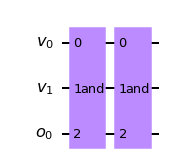

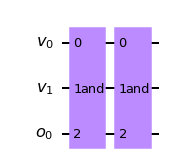

In [3]:
oracle = TruthTableOracle("0101")
oracle.construct_circuit().draw(output='mpl')

Once we have defined the oracle, we can easily create an instance of the Deutsch-Jozsa algorithm and draw the circuit.

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/education/deutsch_jozsa.py:100: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  self._circuit = qc_preoracle + qc_oracle + qc_postoracle
/opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:933: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


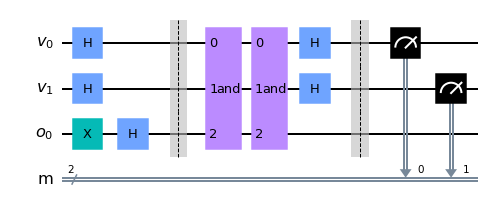

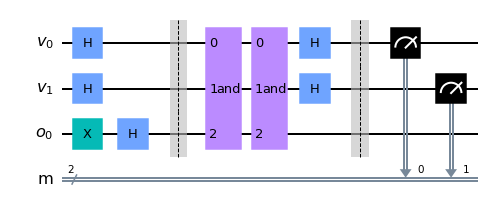

In [4]:
dj = DeutschJozsa(oracle)
dj.construct_circuit(measurement=True).draw(output='mpl')

Obviously, we could execute this circuit on any backend. However, Aqua specifies some extra elements in addition to the circuit, as for instance how the results are to be interpreted.

To execute a quantum algorithm in Aqua, we need to pass it a *QuantumInstance* (which includes the backend and possibly other settings) and the algorithm will use it as many times as need. The result will include information about the execution and, in the case of Deutsch-Jozsa, the final veredict.

In [5]:
backend = qiskit.Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend)
result = dj.run(quantum_instance)
print(result)

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',


{'measurement': {'01': 1024}, 'result': 'balanced'}


Let us check that it also works with constant functions.

In [6]:
oracle2 = TruthTableOracle('00000000')
dj2 = DeutschJozsa(oracle2)
result = dj2.run(quantum_instance)
print("The function is",result['result'])

The function is constant


# Grover

As in the case of Deutsch-Jozsa, for the Aqua implementation of Grover's algorithm we need to provide an oracle. We can also specify the number of iterations.

In [7]:
backend = qiskit.Aer.get_backend('qasm_simulator')
oracle3 = TruthTableOracle('0001')
g = Grover(oracle3, iterations=1)

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/amplitude_amplifiers/grover.py:215: DeprecationWarning: The package qiskit.aqua.algorithms.amplitude_amplifiers is deprecated. It was moved/refactored to qiskit.algorithms.amplitude_amplifiers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.amplitude_amplifiers',


The execution is also similar to the one of Deutsch-Jozsa

In [8]:
result = g.run(quantum_instance)
print(result)

{'measurement': {'11': 1024}, 'top_measurement': '11', 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7faabb72c8b0>, 'assignment': [1, 2], 'oracle_evaluation': True}


It can also be interesting to use oracles that we construct from logical expressions

In [9]:
expression = '(x | y) & (~y | z) & (~x | ~z | w) & (~x | y | z | ~w)'
oracle4 = LogicalExpressionOracle(expression)
g2 = Grover(oracle4, iterations = 3)
result = g2.run(quantum_instance)
print(result)

{'measurement': {'1000': 26, '1110': 28, '0100': 24, '0110': 25, '0011': 27, '0111': 31, '0000': 25, '1001': 28, '0101': 25, '1100': 141, '0010': 150, '1101': 141, '1011': 152, '1010': 14, '1111': 162, '0001': 25}, 'top_measurement': '1111', 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7faab5741ee0>, 'assignment': [1, 2, 3, 4], 'oracle_evaluation': True}


If we do not know the number of solutions or if we do not want to specify the number of iterations, we can use the incremenal mode, that allows us to find a solution in time $O(\sqrt{N})$.

In [10]:
backend = qiskit.Aer.get_backend('qasm_simulator')
expression2 = '(x & y & z & w) | (~x & ~y & ~z & ~w)'
#expression2 = '(x & y) | (~x & ~y)'
oracle5 = LogicalExpressionOracle(expression2, optimization = True)
g3 = Grover(oracle5, incremental = True)
result = g3.run(quantum_instance)
print(result)

{'measurement': {'1110': 9, '1001': 10, '1101': 20, '0001': 13, '0010': 12, '0110': 24, '0100': 15, '0111': 15, '0011': 13, '0000': 421, '1010': 19, '1111': 390, '1011': 16, '1100': 14, '0101': 18, '1000': 15}, 'top_measurement': '0000', 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7faab4eccdf0>, 'assignment': [-1, -2, -3, -4], 'oracle_evaluation': True}
